<a href="https://www.kaggle.com/code/shravankumar147/sam2-kaggle-model?scriptVersionId=192896081" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/segment-anything-2/pytorch/sam2-hiera-large/1/README.md
/kaggle/input/segment-anything-2/pytorch/sam2-hiera-large/1/.gitattributes
/kaggle/input/segment-anything-2/pytorch/sam2-hiera-large/1/sam2_hiera_large.pt
/kaggle/input/segment-anything-2/pytorch/sam2-hiera-large/1/sam2_hiera_l.yaml


In [2]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd /kaggle/working/segment-anything-2
%pip install -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 510 (delta 152), reused 71 (delta 71), pack-reused 304 (from 1)
Receiving objects: 100% (510/510), 88.45 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (160/160), done.
/kaggle/working/segment-anything-2
Obtaining file:///kaggle/working/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cu

In [3]:
import sys
sys.path.append("/kaggle/input/segment-anything-2/pytorch/sam2-hiera-large/1")

In [4]:
!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/groceries.jpg

--2024-08-16 17:03:16--  https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: 'images/truck.jpg'

truck.jpg           100%[===================>] 265.11K  --.-KB/s    in 0.02s   

2024-08-16 17:03:16 (10.6 MB/s) - 'images/truck.jpg' saved [271475/271475]

--2024-08-16 17:03:17--  https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/notebooks/images/groceries.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awa

In [5]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [6]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

np.random.seed(3)

using device: cuda


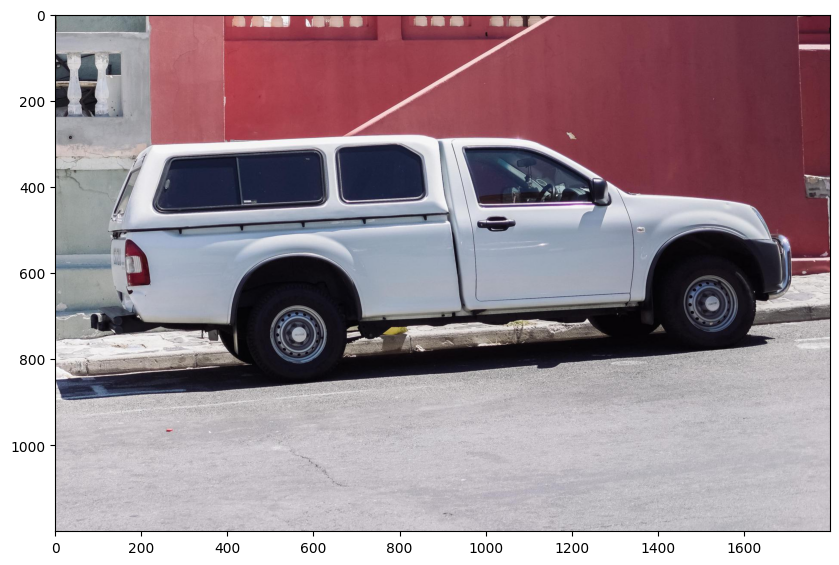

In [7]:
image = Image.open('images/truck.jpg')
image = np.array(image.convert("RGB"))

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [9]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch

checkpoint = "/kaggle/input/segment-anything-2/pytorch/sam2-hiera-large/1/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

In [10]:
with torch.inference_mode(), torch.autocast("cpu", dtype=torch.bfloat16):
    predictor.set_image(image)
    masks, scores, logits = predictor.predict()

In [12]:
scores

array([9.3841553e-04, 2.9325485e-05, 3.8299561e-03], dtype=float32)

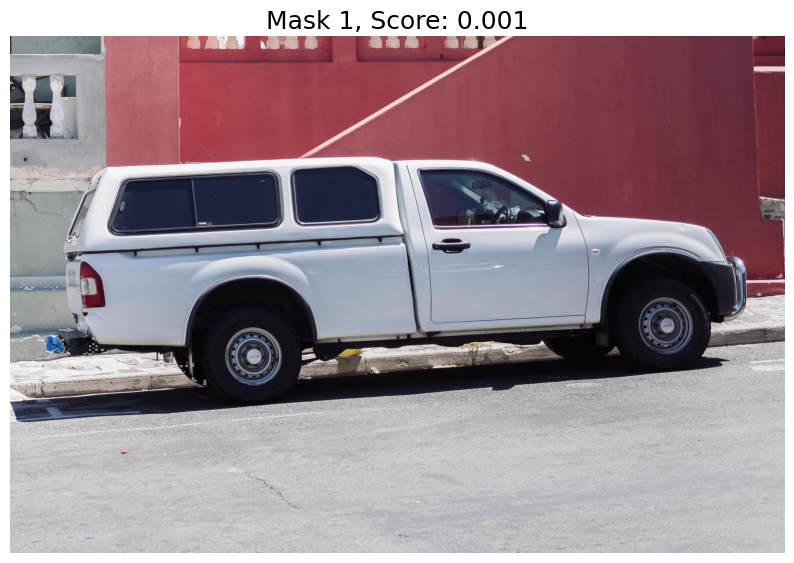

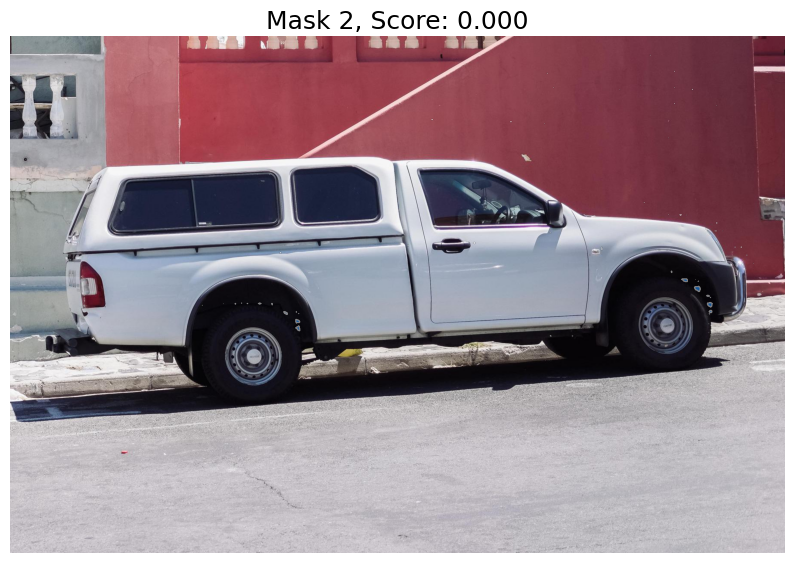

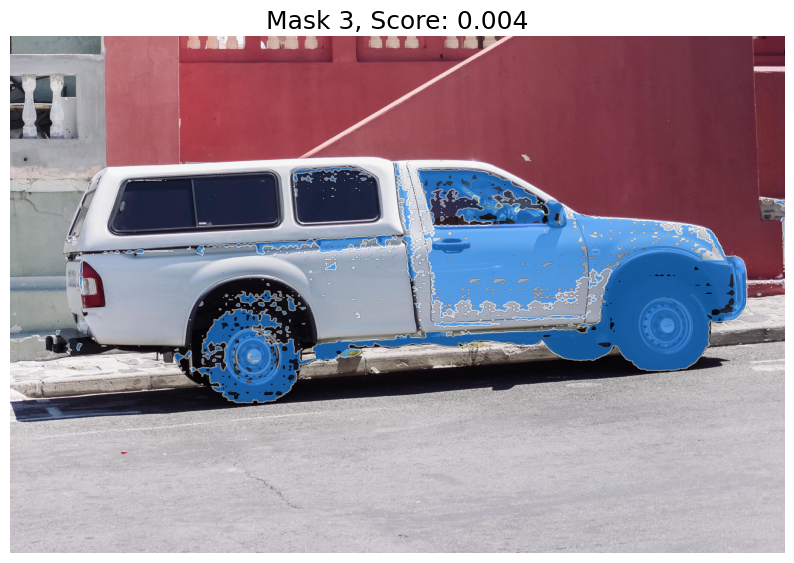

In [11]:
show_masks(image, masks, scores)

## prompt - single point - foreground(1)

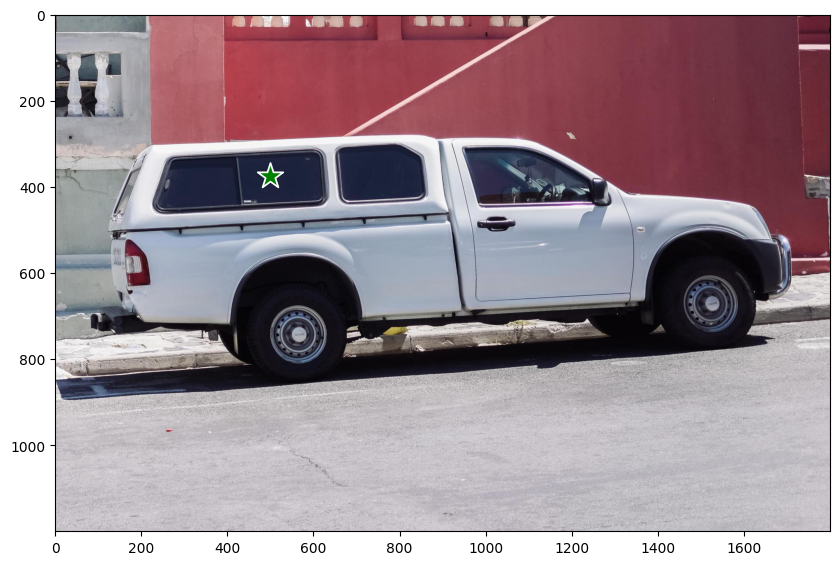

In [13]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

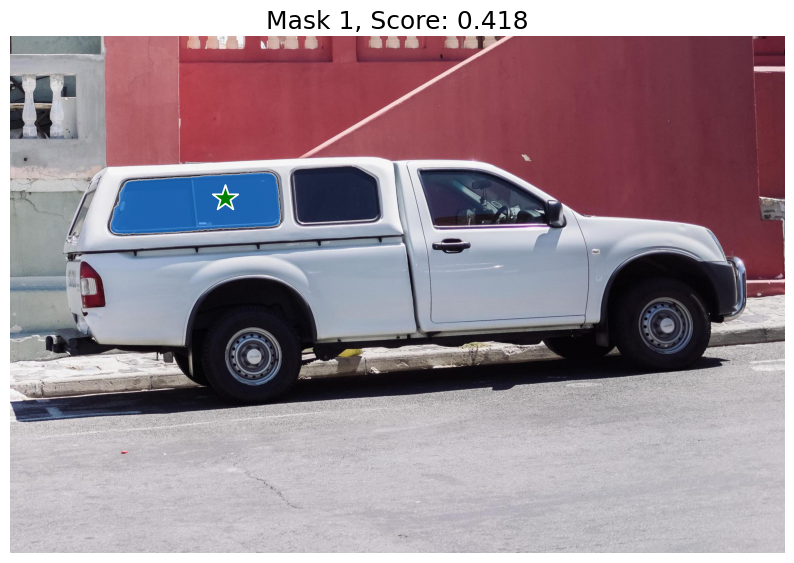

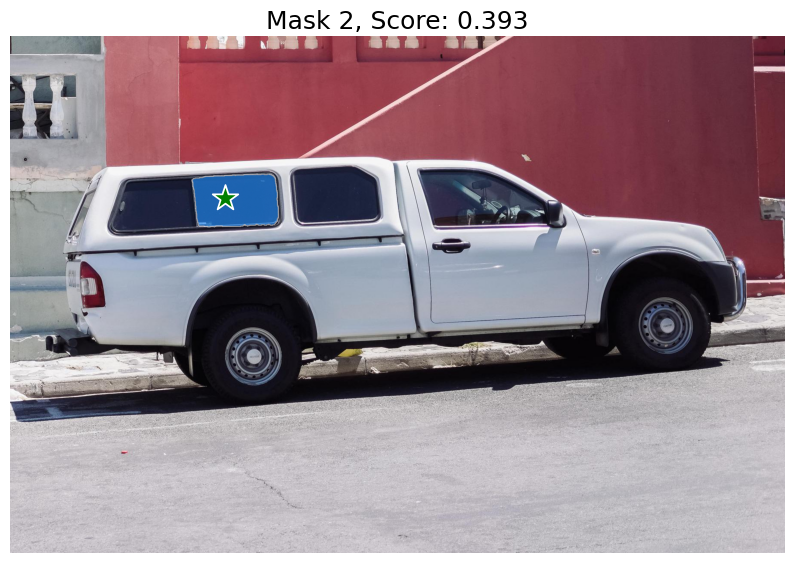

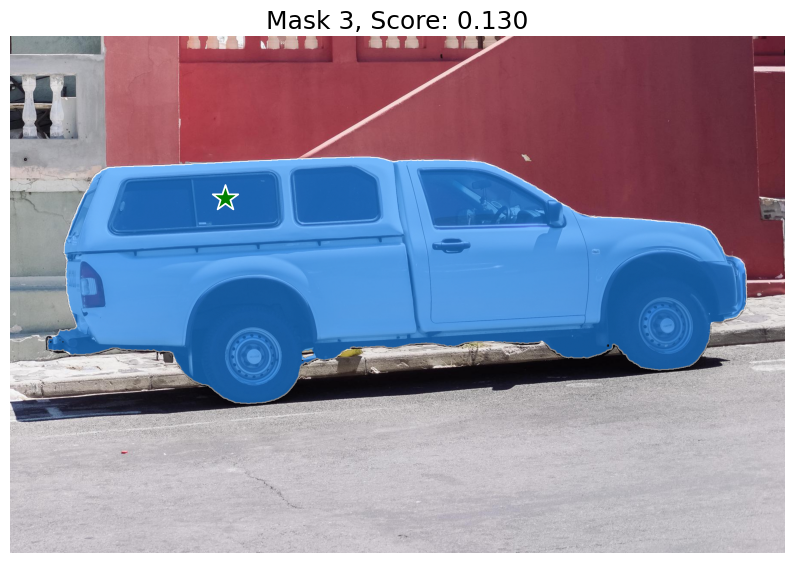

In [14]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)